<a href="https://colab.research.google.com/github/AntonRenker/project4_deep_learning/blob/main/SDL_Project_4_VAE_Implementierung_nach_AssemblyAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders

In [ ]:
# import packages
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import umap
import time

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00


## Data Preparation

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(-0.5, 27.5, 27.5, -0.5)

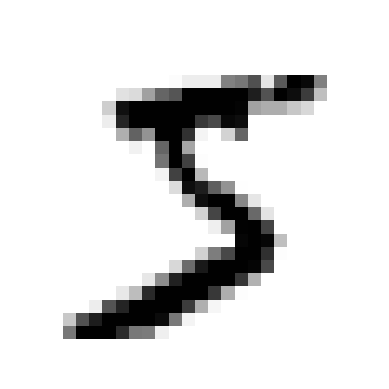

In [ ]:
# load MNIST data
(train_images, train_lables), (test_images, test_lables) = tf.keras.datasets.mnist.load_data()

# display an example image
plt.imshow(train_images[0,:,:], cmap='gray_r')
plt.axis("off")

* each pixel modelled with a Bernoulli distribution
* an outcome of 1 represents a completely white pixel (pixel intensity = 255) and a 0 represents a completely black pixel (pixel intensity = 0)
* scale pixel values to be in the range $[0, 1]$ and then binarize them with a threshold of 0.5
* initialize train_size, test_size and batch_size  
* shuffle dataset to introduce randomness  

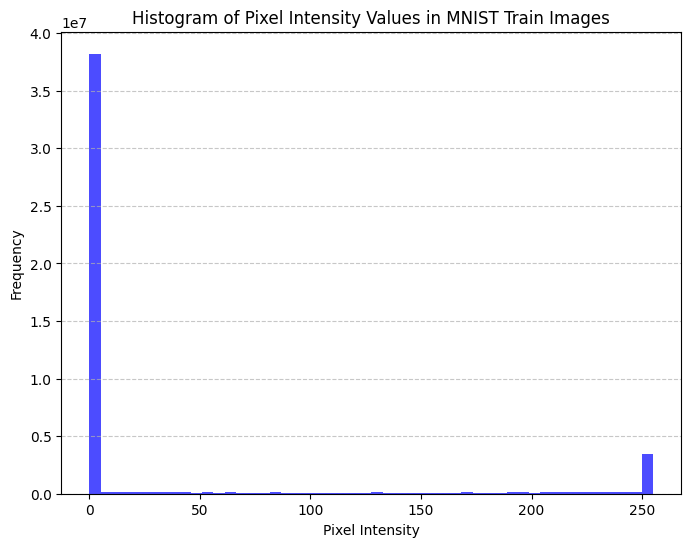

In [ ]:
flattened_pixels = train_images.flatten()

# Plot the histogram of pixel intensity values
plt.figure(figsize=(8, 6))
plt.hist(flattened_pixels, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Pixel Intensity Values in MNIST Train Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


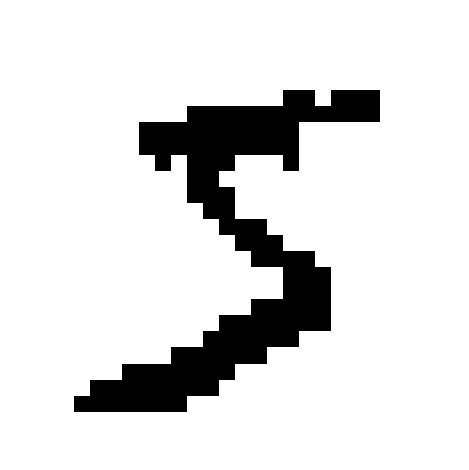

In [ ]:
def preprocess_images(images):
    " This function scales the pixel values to be in [0,1] and then binarize them with a treshold of 0.5."
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

# preprocess train and test images
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# display an examle image
plt.imshow(train_images[0,:,:], cmap='gray_r')
plt.axis("off")
plt.tight_layout()

# initialize size of train and test images and batch size
train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 32

# shuffle and divide the datasets into batches
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Encoder and Decoder
Encoder
* sequence of convolutional layers with ReLU activation, where the final convolution does not have an activation
* so-called "CVAEs" - Convolutional Variational AutoEncoders
* final layer is a dense layer that encodes to twice the size of our latent space to yield parameters for a distribution (mean vector and log variance vector (diagonal of log covariance matrix) with the same dimensionality of the latent space)
* mapping to parameters for a distribution defined on our latent space
* use Gaussians with diagonal log covariance matrices

Decoder
* effectively mirrors the encoder network
* symmetry such that the encoder learns a function $f$ which maps to the latent space and the decoder learns the inverse function $f^-1$ which maps from the latent space back into the original space
* The Conv2DTranspose layers provide learnable upsampling to invert our convolutional layers.

Training Process - Forward Pass Functions

* Encoding Function
  * pass image through encoder to encode it with the caveat that we bifurcate the output
  * split output into two vectors, each with the same dimensionality of the latent space
  * first vector represents the mean of our multivariate Gaussian in the latent space
  * second vector represents the variances of the same Gaussian's diagonal log covariance matrix
* Reparameterization Function
  * we decode a point in the latent space that is randomly sampled according to the distribution defined by the parameters output by our encoding network
  * cannot simply use tf.random.normal() as backprop cannot flow through a random process $\rightarrow$ use reparameterization trick
  * define another random variable which is deterministic in our mean and log variance vectors: take mean and log variance as parameters and maintain stochasticity via a Hadamard product of the log variance vector with a vector whose components are independently sampled from a standard normal distribution
  * Backprop cannot flow through the process that produces the random vector used in the Hadamard product, but that does not matter because we do not need to train this process.
* Decoding Function
  * a latent space point gets passed through the decoder network
  * output either logits directly or their sigmoid (default: do not apply sigmoid for purposes of numerical stability)
* Sampling Function
  * Given a reparameterized sampling from a distribution, the sampling function decodes the input
  * in case of no input, it will randomly input 100 points in the latent space sampled from a standard normal distribution
  * @tf.function to convert the function into a graph for faster execution

In [ ]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential(
              [
                  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                  tf.keras.layers.Conv2D(
                      filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                  tf.keras.layers.Conv2D(
                      filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(latent_dim + latent_dim),
              ]
        )

        # Decoder
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    # Encoding Function
    def encode(self, x):
        # separate output of encoder into mean and log variance
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    # Reparameterization Function
    def reparameterize(self, mean, logvar):
        # sample a standard normal epsilon
        eps = tf.random.normal(shape=mean.shape)
        # reparameterization: construct a normally distributed random variable
        # with mean `mean` and variance exp(logvar)
        return eps * tf.exp(logvar * .5) + mean

    # Decoding Function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    # Sampling Function
    @tf.function
    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)

## Loss Computation
* maximize ELBO
$$\text{ELBO} = E_{q(z|x)} \left [ \log \frac{p(x,z)}{q(z|x)} \right ]$$
* approximate by singe sample Monte Carlo
$$\log p(x|z) + \log p(z) - \log q(z|x)$$
* compute loss function:
  1. Compute the distribution parameters for an image via encoding
  2. Use these parameters to sample from the latent space using the reparameterization trick
  3. Calculate the binary cross entropy between the input image and decoded image (reconstruction loss)
  4. Calculate the values of the conditional distribution, the latent distribution prior (modeled as a unit Gaussian), and the approximate posterior distribution.
  5. Calculate the ELBO
  6. Negate the ELBO and return it as we need to maximize ELBO, but GD minimizes the loss function
* for numerical stability we use `tf.nn.sigmoid_cross_entropy_with_logits()`, which is why we compute logits and do not pass them through sigmoid when decoding


In [ ]:
# Loss Computation
# helper function to compute pdf of standard log-normal distribution
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

# compute loss function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

Details:
`tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)` computes binary cross-entropy and applies sigmoid function on `x_logit`

$$\text{cross_entropy} = -(x \cdot \log(\sigma(x\_logit)) + (1-x) \cdot \log(1- \sigma(x\_logit))$$

and has the same shape as `x_logit` and `x` (cross-entropy loss is applied elementwise). Then `tf.reduce_sum(cross_ent, axis=[1, 2, 3])` sums over the dimensions specified in axis. If `cross_ent` has shape (batch_size, height, width, channels), this reduces the tensor to shape (batch_size, ), where each element represents the total cross-entropy loss for one image in the batch.





## Training Step
* compute loss on a `GradientTape`
* backprop to calculate the gradient
* take a step with optimizer given the gradient
* with `@tf.function` speed up computation

In [ ]:
@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training
Setup
* choose the dimensionality of our latent space to be 2 so that we can visualize the latent space as we did above
* set number of epochs to 10
* instantiate model

Plotting Function
* track how the latent space is characterized during learning
* grid of points in the latent space and passes them through the decoder to generate a landscape of generated images
* how evovle different regions in the latent space to represent features, and how are these feature regions distributed across the space, with continuous transitions between them

Training Loop
* instantiate an Adam optimizer
* enter training loop: iterate through each training batch and executing `train_step()`
* After all batches have been processed, we compute the loss on the test set using the `compute_loss()`, and then return the negative of the average loss to yield the ELBO.
* We return the negative average of the loss here because we flipped the sign in our `compute_loss()` function to use gradient-descent learning.
* If we are within the first epoch, we save a snapshot of the latent space every 75 batches. This is because training happens so quickly that we need this level of granularity at the beginning to observe training. If we are not in the first epoch, we save a snapshot of the latent space at the end of every epoch.

In [ ]:
# training
latent_dim = 3
epochs = 3  # for latent_dim = 2, epochs = 10 funktioniert gut
model = CVAE(latent_dim)

# plotting function
def plot_latent_images(model, n, epoch, im_size=28, save=True, first_epoch=False, f_ep_count=0):

    # Create image matrix
    image_width = im_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    # Create list of values which are evenly spaced wrt probability mass
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))

    # For each point on the grid in the latent space, decode and
    # copy the image into the image array
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (im_size, im_size))
            image[i * im_size: (i + 1) * im_size,
                  j * im_size: (j + 1) * im_size] = digit.numpy()

    # Plot the image array
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')

    # Potentially save, with different formatting if within first epoch
    if save and first_epoch:
        plt.savefig('training_process/tf_grid_at_epoch_{:04d}.{:04d}.png'.format(epoch, f_ep_count))
    elif save:
        plt.savefig('training_process/tf_grid_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# training loop
tf.config.run_functions_eagerly(True)
if latent_dim == 2:
  plot_latent_images(model, 20, epoch=0)

optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for idx, train_x in enumerate(train_dataset):
        # convert train_x to float32
        train_x = tf.cast(train_x, dtype=tf.float32)
        train_step(model, train_x, optimizer)
        # plot latent image in epoch 1 for every 75th batch
        if epoch == 1 and idx % 75 == 0 and latent_dim == 2:
            plot_latent_images(model, 20, epoch=epoch, first_epoch=True, f_ep_count=idx)
    end_time = time.time()
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        # Convert test_x to float32
        test_x = tf.cast(test_x, dtype=tf.float32)
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    if epoch != 1 and latent_dim ==2:
        plot_latent_images(model, 20, epoch=epoch)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch: 1, Test set ELBO: -169.29745483398438, time elapse for current epoch: 267.37138175964355
Epoch: 2, Test set ELBO: -156.8891143798828, time elapse for current epoch: 264.6587116718292
Epoch: 3, Test set ELBO: -151.972900390625, time elapse for current epoch: 260.62137389183044


## Results

* string together the snapshots during training
* visualizes how VAE learns to associate distinct features to different regions in the latent space and organizes these regions based on similarity to allow for a continuous transition between them

In [ ]:
anim_file = 'grid2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('training_process/tf_grid*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

training_process/tf_grid_at_epoch_0000.png
training_process/tf_grid_at_epoch_0001.0000.png
training_process/tf_grid_at_epoch_0001.0300.png


<ipython-input-10-8dd952696839>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


training_process/tf_grid_at_epoch_0001.0600.png
training_process/tf_grid_at_epoch_0001.0900.png
training_process/tf_grid_at_epoch_0001.1200.png
training_process/tf_grid_at_epoch_0001.1500.png
training_process/tf_grid_at_epoch_0001.1800.png
training_process/tf_grid_at_epoch_0002.png
training_process/tf_grid_at_epoch_0003.png
training_process/tf_grid_at_epoch_0004.png
training_process/tf_grid_at_epoch_0005.png
training_process/tf_grid_at_epoch_0006.png
training_process/tf_grid_at_epoch_0007.png
training_process/tf_grid_at_epoch_0008.png
training_process/tf_grid_at_epoch_0009.png
training_process/tf_grid_at_epoch_0010.png


<ipython-input-10-8dd952696839>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
